In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Function to trim trailing zeros from sequences
def trim_zeros(row):
    reversed_row = row[::-1]
    non_zero_indices = np.where(reversed_row != 0)[0]
    if len(non_zero_indices) == 0:
        return np.array([])
    first_non_zero = non_zero_indices[0]
    end = len(row) - first_non_zero
    return row[:end]

# Load and process data
normal_df = pd.read_csv('../dataset/ptbdb_normal.csv', header=None)
abnormal_df = pd.read_csv('../dataset/ptbdb_abnormal.csv', header=None)

# Delete last columns of 2 datasets
normal_df = normal_df.drop(normal_df.columns[187], axis=1)
abnormal_df = abnormal_df.drop(abnormal_df.columns[187], axis=1)

normal_sequences = []
abnormal_sequences = []

for row in normal_df.values:
    trimmed = trim_zeros(row)
    if len(trimmed) > 0:
        normal_sequences.append(trimmed)

for row in abnormal_df.values:
    trimmed = trim_zeros(row)
    if len(trimmed) > 0:
        abnormal_sequences.append(trimmed)

# Create labeled dataset
labels_normal = [0] * len(normal_sequences)
labels_abnormal = [1] * len(abnormal_sequences)
all_sequences = normal_sequences + abnormal_sequences
all_labels = labels_normal + labels_abnormal

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_sequences, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f'Normal Data:   {len(normal_sequences)}')
print(f'Abnormal Data: {len(abnormal_sequences)}')


Normal Data:   4046
Abnormal Data: 10506


In [4]:
# Modified Dataset class with long tensors for labels
class HeartbeatDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

# Collate function for DataLoaders to handle variable length sequences
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    padded_sequences = padded_sequences.unsqueeze(-1)
    labels = torch.stack(labels)
    return padded_sequences, labels, lengths

# Create DataLoaders
batch_size = 32
train_dataset = HeartbeatDataset(X_train, y_train)
test_dataset = HeartbeatDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [5]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
    
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        output, (hidden, _) = self.lstm(packed)
        out = self.fc(hidden[-1, :, :])
        return out


# Initialize model with CrossEntropyLoss and Adam optimizer
input_size = 1
hidden_size = 64
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/60
Train Loss: 0.5922 | Train Acc: 72.19%
Test Loss:  0.5913 | Test Acc:  72.21%

Epoch 2/60
Train Loss: 0.5924 | Train Acc: 72.19%
Test Loss:  0.5921 | Test Acc:  72.21%

Epoch 3/60
Train Loss: 0.5914 | Train Acc: 72.19%
Test Loss:  0.5803 | Test Acc:  72.21%

Epoch 4/60
Train Loss: 0.5902 | Train Acc: 72.19%
Test Loss:  0.5890 | Test Acc:  72.21%

Epoch 5/60
Train Loss: 0.5639 | Train Acc: 72.20%
Test Loss:  0.5202 | Test Acc:  71.87%

Epoch 6/60
Train Loss: 0.5195 | Train Acc: 72.34%
Test Loss:  0.5057 | Test Acc:  74.20%

Epoch 7/60
Train Loss: 0.4991 | Train Acc: 73.57%
Test Loss:  0.5071 | Test Acc:  71.08%

Epoch 8/60
Train Loss: 0.4991 | Train Acc: 73.79%
Test Loss:  0.4893 | Test Acc:  73.55%

Epoch 9/60
Train Loss: 0.4691 | Train Acc: 76.09%
Test Loss:  0.4616 | Test Acc:  75.99%

Epoch 10/60
Train Loss: 0.5287 | Train Acc: 75.05%
Test Loss:  0.5971 | Test Acc:  72.21%

Epoch 11/60
Train Loss: 0.5923 | Train Acc: 72.19%
Test Loss:  0.5905 | Test Acc:  72.21%

Epoch 12

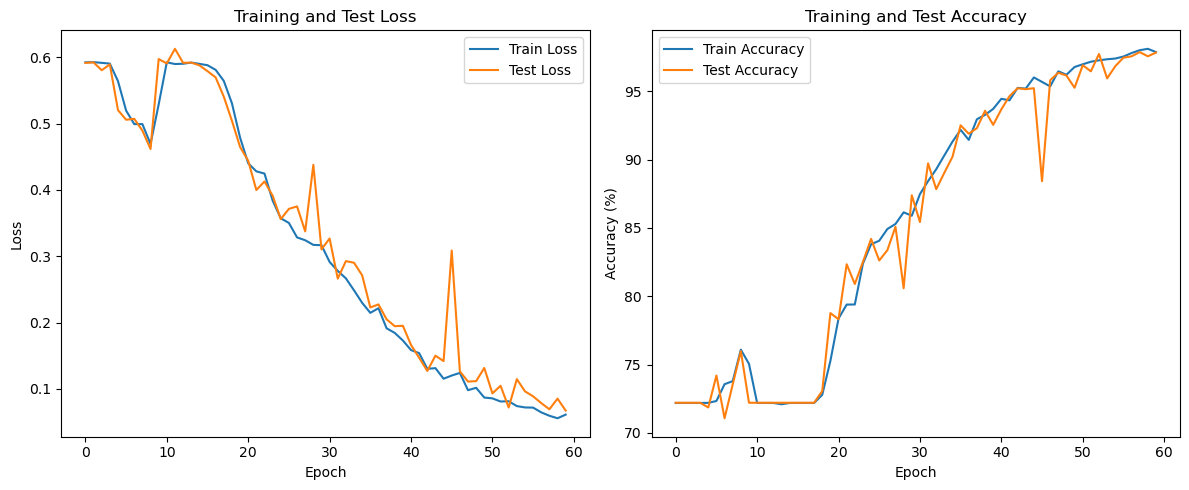

In [6]:
# Training setup
num_epochs = 60
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Modified training loop for CrossEntropy
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch in train_loader:
        x, y, lengths = batch
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x, lengths)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)  # Get class predictions
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)
    
    # Calculate training metrics
    train_loss = epoch_train_loss / total_train
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluation
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for x, y, lengths in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x, lengths)
            loss = criterion(outputs, y)
            
            test_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == y).sum().item()
            total_test += y.size(0)
    
    # Calculate test metrics
    test_loss = test_loss / total_test
    test_acc = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%\n')

# Plotting remains the same
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Final evaluation with precision/recall
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for x, y, lengths in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x, lengths)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Generate classification report
class_names = ['Normal', 'Abnormal']
report = classification_report(
    all_targets, all_preds, 
    target_names=class_names, 
    digits=4,
    output_dict=True
)

# Print formatted metrics
print("\nClassification Report:")
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
for cls in class_names:
    print(f"{cls:<10} {report[cls]['precision']:.4f}     {report[cls]['recall']:.4f}      {report[cls]['f1-score']:.4f}       {report[cls]['support']}")

print("\nWeighted Averages:")
print(f"{'Precision':<10} {report['weighted avg']['precision']:.4f}")
print(f"{'Recall':<10} {report['weighted avg']['recall']:.4f}")
print(f"{'F1-Score':<10} {report['weighted avg']['f1-score']:.4f}")


Classification Report:
Class      Precision  Recall     F1-Score   Support   
Normal     0.9698     0.9518      0.9607       809.0
Abnormal   0.9816     0.9886      0.9851       2102.0

Weighted Averages:
Precision  0.9783
Recall     0.9784
F1-Score   0.9783


In [9]:
# Save the model in directory model
torch.save(model.state_dict(), '../model/lstm_model.pth')
print('Model saved successfully!')

Model saved successfully!
